# T<sub>2</sub> Ramey Characterization

This experiment serves as one of the series of experiments used to characterize a single qubit. Its purpose is to determine two of the qubit's properties: *Ramsey* or *detuning frequency* and $T_2\ast$. The rough frequency of the qubit was already determined previously. Here, we would like to measure the *detuning*, that is  the difference between the qubit's precise frequency and the frequency of the rotation pulses (based on the rough frequency). This part of the experiment is called a *Ramsey Experiment*. $T_2\ast$ represents the rate of decay toward a mixed state, when the qubit is initialized to the |+⟩ state.

In [1]:
import qiskit
from qiskit_experiments.library import T2Ramsey

The circuit used for the experiment comprises the following:

    1. Hadamard gate
    2. delay
    3. p (phase) gate that rotates the qubit in the x-y plane 
    4. Hadamard gate
    5. measurement

During the delay time, we expect the qubit to precess about the z-axis. If the p gate and the precession offset each other perfectly, then the qubit will arrive at the |0⟩ state (after the second Hadamard gate). By varying the extension of the delays, we get a series of oscillations of the qubit state between the |0⟩ and |1⟩ states. We can draw the graph of the resulting function, and can analytically extract the desired values.

In [2]:
# set the computation units to microseconds
unit = 'us' #microseconds
qubit = 0
# set the desired delays
delays = list(range(1, 150, 2))

In [3]:
# Create a T2Ramsey experiment. Print the first circuit as an example
exp1 = T2Ramsey(qubit, delays, unit=unit)
print(exp1.circuits()[0])

     ┌───┐┌──────────────┐┌──────┐ ░ ┌───┐ ░ ┌─┐
q_0: ┤ H ├┤ Delay(1[us]) ├┤ P(0) ├─░─┤ H ├─░─┤M├
     └───┘└──────────────┘└──────┘ ░ └───┘ ░ └╥┘
c: 1/═════════════════════════════════════════╩═
                                              0 


We run the experiment on a simple, simulated backend, created specifically for this experiment's tutorial.

In [4]:
from qiskit_experiments.test.t2ramsey_backend import T2RamseyBackend
# FakeJob is a wrapper for the backend, to give it the form of a job
from qiskit_experiments.test.utils import FakeJob
import qiskit_experiments.matplotlib
from qiskit_experiments.matplotlib import pyplot, requires_matplotlib
from qiskit_experiments.matplotlib import HAS_MATPLOTLIB

conversion_factor = 1E-6
# The behavior of the backend is determined by the following parameters
backend = T2RamseyBackend(
                    p0={"a_guess":[0.5], "t2ramsey":[80.0], "f_guess":[0.02], "phi_guess":[0.0],
                        "b_guess": [0.5]},
                    initial_prob_plus=[0.0],
                    readout0to1=[0.02],
                    readout1to0=[0.02],
                    conversion_factor=conversion_factor,
                )


The resulting graph will have the form:
$f(t) = a^{-t/T_2*} \cdot \cos(2 \pi f t + \phi) + b$
where *t* is the delay, $T_2*$ is the decay factor, and *f* is the detuning frequency.
`conversion_factor` is a scaling factor that depends on the measurement units used. It is 1E-6 here, because the unit is microseconds.

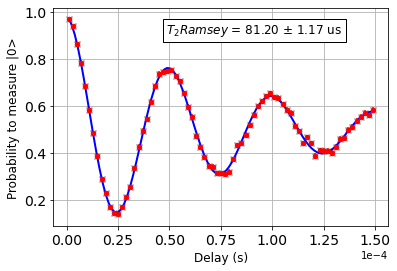

In [5]:
exp1.set_analysis_options(user_p0=None, plot=True)
expdata1 = exp1.run(backend=backend, shots=2000)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

In [6]:
# Print results
for result in expdata1.analysis_results():
    print(result)

DbAnalysisResultV1
- name: T2
- value: 8.119888734798959e-05 ± 1.1732134066317724e-06 s
- χ²: 1.0009782741856124
- quality: good
- extra: <9 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: Frequency
- value: 19986.28552215432 ± 36.786715681775256 Hz
- χ²: 1.0009782741856124
- quality: good
- extra: <9 items>
- device_components: ['Q0']
- verified: False


Additional fitter result data is stored in the `result.extra` field

In [7]:
expdata1.analysis_results("T2").extra

{'popt': array([ 4.80800910e-01,  8.11988873e-05,  1.99862855e+04, -3.54455353e-04,
         5.00308274e-01]),
 'popt_keys': None,
 'popt_err': array([3.08570554e-03, 1.17321341e-06, 3.67867157e+01, 1.10646031e-02,
        1.23281264e-03]),
 'pcov': array([[ 9.52157866e-06, -2.23211135e-09, -2.20537487e-02,
          9.47235960e-06, -6.05452905e-07],
        [-2.23211135e-09,  1.37642970e-12,  3.50045599e-06,
         -1.78851861e-09,  2.03470998e-10],
        [-2.20537487e-02,  3.50045599e-06,  1.35326245e+03,
         -3.13821719e-01, -1.16770979e-02],
        [ 9.47235960e-06, -1.78851861e-09, -3.13821719e-01,
          1.22425442e-04,  3.93775838e-06],
        [-6.05452905e-07,  2.03470998e-10, -1.16770979e-02,
          3.93775838e-06,  1.51982702e-06]]),
 'reduced_chisq': 1.0009782741856124,
 'dof': 70,
 'x_range': (1e-06, 0.000149),
 'y_range': (0.139, 0.9685),
 'circuit_unit': 'us'}

### Providing initial user estimates
The user can provide initial estimates for the parameters to help the analysis process. Because the curve is expected to decay toward $0.5$, the natural choice for parameters $A$ and $B$ is $0.5$. Varying the value of $\phi$ will shift the graph along the x-axis. Since this is not of interest to us, we can safely initialize $\phi$ to 0. In this experiment, `t2ramsey` and `f` are the parameters of interest. Good estimates for them are values computed in previous experiments on this qubit or a similar values computed for other qubits.

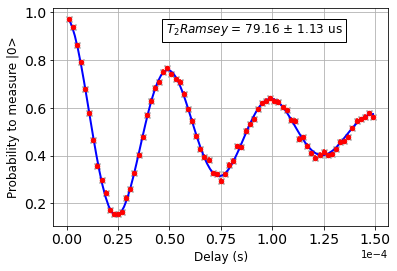

In [8]:
from qiskit_experiments.library.characterization import T2RamseyAnalysis
user_p0={
    "A": 0.5,
    "t2ramsey": 85.0,
    "f": 0.021,
    "phi": 0,
    "B": 0.5
        }
exp_with_p0 = T2Ramsey(qubit, delays, unit=unit)
exp_with_p0.set_analysis_options(user_p0=user_p0, plot=True)
expdata_with_p0 = exp_with_p0.run(backend=backend, shots=2000)
expdata_with_p0.block_for_results()

# Display fit figure
display(expdata_with_p0.figure(0))

In [9]:
# Print results
for result in expdata_with_p0.analysis_results():
    print(result)

DbAnalysisResultV1
- name: T2
- value: 7.915718737165832e-05 ± 1.1329893873203315e-06 s
- χ²: 1.0869594929113429
- quality: good
- extra: <9 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: Frequency
- value: 19987.370511089972 ± 37.61732462688318 Hz
- χ²: 1.0869594929113429
- quality: good
- extra: <9 items>
- device_components: ['Q0']
- verified: False


The units can be changed, but the output in the result is always given in seconds. The units in the backend must be adjusted accordingly.

In [10]:
from qiskit.utils import apply_prefix
unit = 'ns'
delays = list(range(1000, 150000, 2000))
conversion_factor = apply_prefix(1, unit)
print(conversion_factor)

1e-09


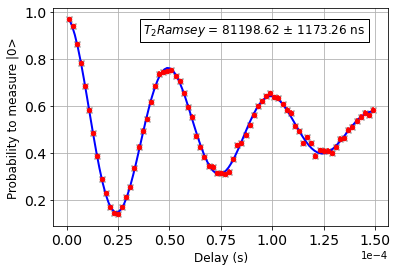

In [11]:
p0={"a_guess":[0.5], "t2ramsey":[80000], "f_guess":[0.00002], "phi_guess":[0.0],
                        "b_guess": [0.5]}
backend_in_ns = T2RamseyBackend(
                    p0=p0,
                    initial_prob_plus=[0.0],
                    readout0to1=[0.02],
                    readout1to0=[0.02],
                    conversion_factor=conversion_factor
                )
exp_in_ns = T2Ramsey(qubit, delays, unit=unit)
exp_in_ns.set_analysis_options(user_p0=None, plot=True)

# Run experiment
expdata_in_ns = exp_in_ns.run(backend=backend_in_ns, shots=2000).block_for_results()

# Display Figure
display(expdata_in_ns.figure(0))

In [12]:
# Print Results
for result in expdata_in_ns.analysis_results():
    print(result)

DbAnalysisResultV1
- name: T2
- value: 8.119862424623404e-05 ± 1.1732636834226005e-06 s
- χ²: 1.0009782748971077
- quality: good
- extra: <9 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: Frequency
- value: 99019986.2856958 ± 36.787757148659125 Hz
- χ²: 1.0009782748971077
- quality: good
- extra: <9 items>
- device_components: ['Q0']
- verified: False


In [13]:
import qiskit.tools.jupyter
%qiskit_copyright